In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter
from hmmlearn import hmm


import sys
sys.path.append("../src")
from fast_open_data import open_data_filter
from data_conversions import transition_matrix, sep_modo

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [61]:
S, R, L = open_data_filter(52, key = 'S1_Synched')
S1, R1, L1 = open_data_filter(23, key = 'S1_Synched')

In [111]:
freq_amostragem = 120
# dados para voluntário 52

sep = 465
# Sentar
est_sit_S = [ 140, 264, 365]
seq_sit_S = [1, 2, 3, 1]
S_sit = S[:sep]
classes_sit = np.unique(seq_sit_S)

# Levantar
est_rise_S = [570-sep, 647-sep, 725-sep]
seq_rise_S = [1, 2, 3, 1]
S_rise = S[sep:]
classes_rise = np.unique(seq_rise_S)

In [112]:
modo_rise_S, V_seq_rise_S, V_modo_rise_S, Var_seq_rise_S, Var_modo_rise_S = sep_modo(S_rise, est_rise_S, seq_rise_S, classes_rise)

In [113]:
transitions_rise = transition_matrix(modo_rise_S, classes_rise)

In [114]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)

In [115]:
model.startprob_ = np.array([0.8, 0.1, 0.1])

In [116]:
model.transmat_ = transitions_rise

In [117]:
model.means_ = np.array([[S_rise[0], V_modo_rise_S[0]], 
                         [S_rise[est_rise_S[0]], V_modo_rise_S[1]], 
                         [S_rise[est_rise_S[1]], V_modo_rise_S[2]]])

In [118]:
model.covars_ = np.array([[[Var_modo_rise_S[0], 0],[0, Var_modo_rise_S[0]]], 
                          [[Var_modo_rise_S[1], 0],[0, Var_modo_rise_S[1]]],
                          [[Var_modo_rise_S[2], 0],[0, Var_modo_rise_S[2]]]])

In [119]:
for i in range(len(V_modo_rise_S)):
    idx = np.where(modo_rise_S == i+1)[0]
    modo_rise_S[idx] = V_modo_rise_S[i] 

In [120]:
predict = np.c_[S_rise, modo_rise_S]

In [121]:
Z2 = model.predict(predict)

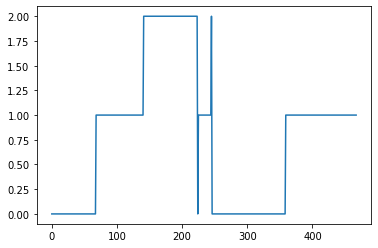

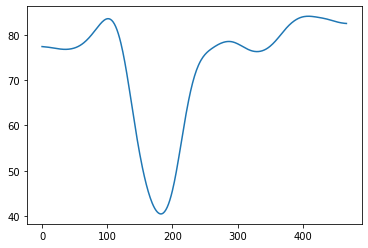

In [122]:
plt.plot(Z2)
plt.show()
plt.plot(S_rise)

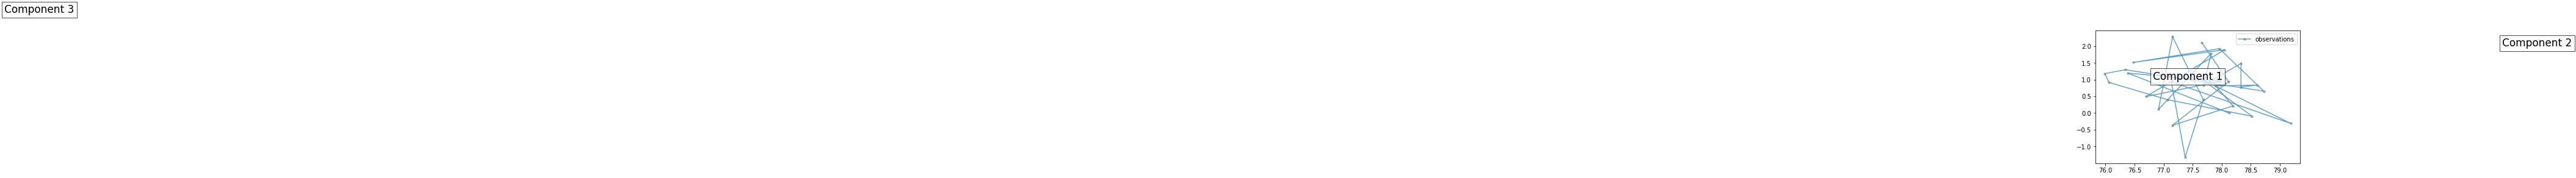

In [53]:
startprob = np.array([0.8, 0.1, 0.1])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat =transitions_rise
# The means of each component
means = np.array([[S_rise[0], 1], 
                  [S_rise[est_rise_S[0]], 2], 
                  [S_rise[est_rise_S[1]], 3]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (3, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars
###############################################################

# Generate samples
X, Z = model.sample(30)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

In [8]:
X = np.concatenate([angle_Spine_filter, angle_RightUpLeg_filter])
Y = np.concatenate([angle_Spine_filter, angle_LeftUpLeg_filter])
lengths = [len(angle_Spine_filter), len(angle_RightUpLeg_filter)]
f=int(len(X)/2)

In [9]:
Y = Y/max(Y)

In [10]:
predict = np.zeros([Y.shape[0],2])
#predict = np.zeros([X.shape[0],1])

In [11]:
predict[:,0] = X[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
predict[0:140,1] = 0
predict[140:370,1] = 1
predict[370:570,1] = 2
predict[570:865,1] = 1
predict[865:f,1] = 0
predict[f:1013,1] = 0
predict[1013:1243,1] = 1
predict[1243:1443,1] = 2
predict[1443:1738,1] = 1
predict[1738:,1] = 0

In [12]:
f

893

In [13]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100).fit(predict, lengths)
Z2 = remodel.predict(predict)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\hmmlearn\hmm.py:208: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(X)


In [14]:
remodel.monitor_

ConvergenceMonitor(
    history=[9054.802487655024, 48007.14297074525, 48007.14297074525],
    iter=3,
    n_iter=100,
    tol=0.01,
    verbose=False,
)

In [15]:
#remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)

In [16]:
#remodel.fit(predict)

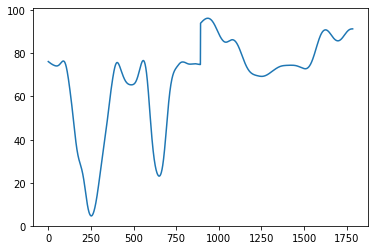

In [17]:
plt.plot(X)

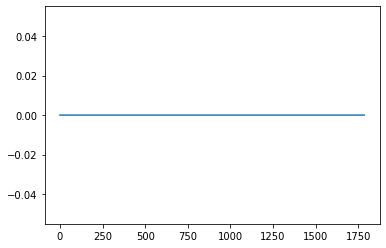

In [18]:
plt.plot(Z2)

In [19]:
k=f

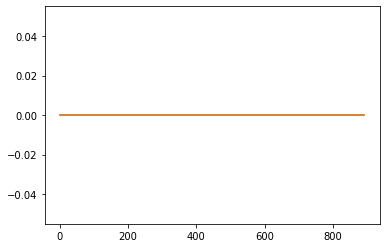

In [20]:
plt.plot(Z2[:k])
plt.plot(Z2[k:])

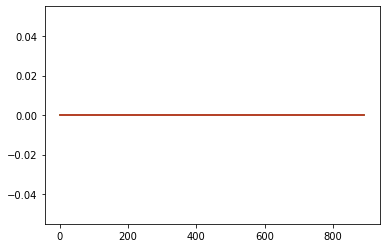

In [21]:
plt.plot(predict[:f])
plt.plot(predict[f:])

In [22]:
W = remodel.decode(predict, algorithm='viterbi')

In [23]:
W

(46045.02142318516, array([0, 0, 0, ..., 0, 0, 0]))

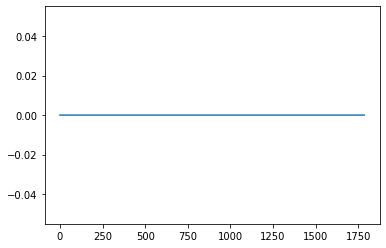

In [24]:
plt.plot(W[1])
#plt.plot(Z2)

In [25]:
remodel.transmat_

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [26]:
remodel.startprob_

array([0.33333333, 0.33333333, 0.33333333])

In [27]:
remodel.means_

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [28]:
remodel.covars_

array([[[1.67973124e-05, 1.67973124e-05],
        [1.67973124e-05, 1.67973124e-05]],

       [[1.67973124e-05, 1.67973124e-05],
        [1.67973124e-05, 1.67973124e-05]],

       [[1.67973124e-05, 1.67973124e-05],
        [1.67973124e-05, 1.67973124e-05]]])